In [1]:
import os, shutil

import cv2  # opencv
import numpy as np

from keras_facenet import FaceNet
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN
from scipy.spatial import distance
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
scaller = StandardScaler()
model = FaceNet().model
detector = MTCNN() # Медленно работает TODO: выпилить
face_cascade=cv2.CascadeClassifier('../cascade/haarcascade_frontalface_default.xml')

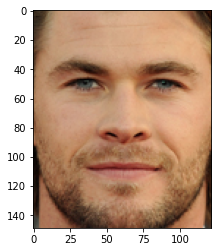

In [3]:
frame_test = cv2.imread('../images/Chris Hemsworth.jpg')
gray_test=cv2.cvtColor(frame_test,cv2.COLOR_BGR2RGB)
face_test_coord=face_cascade.detectMultiScale(gray_test,scaleFactor=1.2,minNeighbors=15)
face_test_coord= [face['box'] for face in detector.detect_faces(frame_test)]
for (x_face,y_face,w_face,h_face) in face_test_coord:
    plt.imshow(gray_test[y_face:y_face+h_face, x_face:x_face+w_face])

In [4]:
class CustomScaller:
    def fit_transform(self, x:np.ndarray):
        # Не определился ещё
        # mean = np.mean(x, keepdims=True)
        # std = np.std(x, keepdims=True)
        # return (x - mean) / std
        max = np.max(x, keepdims=True)
        min = np.min(x, keepdims=True)
        return (x - min) / (max - min)

def norm(x, scaller=None):
    if scaller is None:
        scaller = CustomScaller()
    return scaller.fit_transform(x)

In [6]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output
# l2_normalize(cv2.resize(frame_test[y_face:y_face+h_face, x_face:x_face+w_face], (160, 160)))

In [7]:
def get_embeding(x:np.ndarray):
    return model.predict(
        norm(cv2.resize(x, (160, 160))
             .reshape(-1,160,160,3))
    )
emb = get_embeding(cv2.resize(frame_test[y_face:y_face+h_face, x_face:x_face+w_face], (160, 160)))

distance.euclidean(emb, emb)

0.0

In [8]:
def get_embedded_from_image(image):
    emb = []
    detected_faces = face_cascade.detectMultiScale(image,scaleFactor=1.2,minNeighbors=15)
    for (x_face,y_face,w_face,h_face) in detected_faces:
        emb.append(get_embeding(image[y_face:y_face+h_face,x_face:x_face+w_face]))
    return emb


def load_embeded_from_file(files_in:list):
    embeded = {}
    for file_in in files_in:
        frame_test = cv2.imread(file_in)
        gray_test = cv2.cvtColor(frame_test,cv2.COLOR_BGR2GRAY)
        # detected_faces = [face['box'] for face in detector.detect_faces(frame_test)]
        detected_faces = face_cascade.detectMultiScale(gray_test,scaleFactor=1.2,minNeighbors=15)
        emb = []
        for (x_face,y_face,w_face,h_face) in detected_faces:
          emb.append({'embeded': get_embeding(frame_test[y_face:y_face+h_face,x_face:x_face+w_face]), 'axis': [x_face,y_face,w_face,h_face]})
        embeded[file_in] = emb
    return embeded

In [9]:
default_path = '../images'
train_y = [default_path + '/' + c for c in os.listdir(path=default_path)]
train_x = load_embeded_from_file(train_y)
files_name = [c for c in os.listdir(path=default_path)]

In [10]:
test_y = ['../test/3840x2160-avengers-cast-photocall-moscow-05.JPG']
test_x = load_embeded_from_file(test_y)

In [10]:
for c in test_x:
    for emb in test_x[c]:
        print(distance.euclidean(emb['embeded'], train_x[train_y[0]][0]['embeded']))


0.720110297203064
1.2011101245880127
1.2857176065444946
1.4266481399536133
1.4797662496566772


In [11]:
def predict(test_x, train_x, train_y):
    res = []
    for keys_test in test_x:
        for embeding_test  in test_x[keys_test]:
            min = 100
            res.append({'data_y':None, 'axis_test': embeding_test['axis']})
            for indx,keys_train in enumerate(train_x):
                for embeding_train in train_x[keys_train]:
                    dstns = distance.euclidean(embeding_test['embeded'], embeding_train['embeded'])
                    if dstns < 1 and min > dstns:
                        min = dstns
                        res[-1] = {'data_y':train_y[indx], 'axis_test':embeding_test['axis']}

        return res

predict(test_x, train_x, train_y)

[{'data_y': '../images/Chris Hemsworth.jpg',
  'axis_test': [810, 260, 154, 154]},
 {'data_y': '../images/Robert Downey Jr..jpg',
  'axis_test': [1719, 336, 213, 213]},
 {'data_y': '../images/Mark Ruffalo.jpg', 'axis_test': [2247, 347, 183, 183]},
 {'data_y': '../images/Jeremy Renner.jpg', 'axis_test': [187, 369, 172, 172]},
 {'data_y': '../images/Scarlett Johansson .jpg',
  'axis_test': [1207, 407, 160, 160]}]

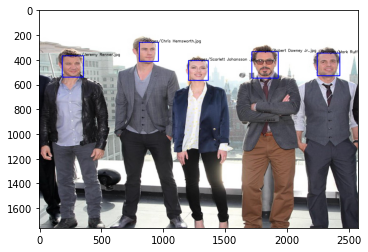

In [83]:
frame_test = cv2.imread(test_y[0])
(x_face,y_face,w_face,h_face) = test_x[test_y[0]][0]['axis']

test_y_predicted_many = predict(test_x, train_x, train_y)

frame_test = cv2.cvtColor(frame_test, cv2.COLOR_BGR2RGB)
for test_y_predicted in test_y_predicted_many:
    cv2.rectangle(
        frame_test,
        (test_y_predicted['axis_test'][0], test_y_predicted['axis_test'][1]),
        (test_y_predicted['axis_test'][0] + test_y_predicted['axis_test'][2], test_y_predicted['axis_test'][1] + test_y_predicted['axis_test'][3]),
        (0, 0, 255),
        6
    )
    cv2.putText(
        frame_test,
        test_y_predicted['data_y'] if test_y_predicted['data_y'] is not None else 'Undefined',
        (test_y_predicted['axis_test'][0], test_y_predicted['axis_test'][1]),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 0),
        2
    )
plt.imshow(frame_test)

In [38]:
# celebrity_dataset_path = '../dataset/img_align_celeba'
# data_y = [celebrity_dataset_path + '/' + c for c in os.listdir(path=celebrity_dataset_path)]
# data_x = load_embeded_from_file(data_y)

In [16]:
data_y = [int(s.split(' ')[1][:-1]) for s in open("../dataset/identity_CelebA.txt").readlines()]
kf = KFold(n_splits=2)

train_index, test_index = kf.split(data_y)
print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: (array([101300, 101301, 101302, ..., 202596, 202597, 202598]), array([     0,      1,      2, ..., 101297, 101298, 101299])) TEST: (array([     0,      1,      2, ..., 101297, 101298, 101299]), array([101300, 101301, 101302, ..., 202596, 202597, 202598]))


In [12]:
dictionary = {}
with open('../dataset/identity_CelebA.txt') as f:
    for line in f:
        fl_nm, clss = line.split(' ')
        clss = clss[:-1]
        if clss in dictionary:
            dictionary[clss].append(fl_nm)
        else:
            dictionary[clss] = [fl_nm]

deleted_keys = list(filter(lambda key: dictionary[key].__len__() < 10, dictionary.keys()))
# deleted_keys = dict.fromkeys(deleted_keys).keys()
for key in deleted_keys:
    dictionary.pop(key)

In [28]:
for key in dictionary:
    if dictionary[key].__len__() < 10:
        print(key, end=';')

In [26]:
src_path = '../dataset/img_align_celeba'
dest_path = '../dataset/img_align_sorted'

for key in dictionary:
    if dictionary[key].__len__() > 10:
        for file in dictionary[key]:
            if not os.path.exists(dest_path + '/' + key):
                os.mkdir(dest_path + '/' + key)
            shutil.copy(src_path + '/' + file, dest_path + '/' + key + '/' + file)

NameError: name 'dictionary' is not defined

In [14]:
import os
import cv2  # opencv
from sklearn.model_selection import KFold

dest_path = '../dataset/img_align_sorted'

kf = KFold(n_splits=2)
test_y, test_x, train_x, train_y = [[], [], [], []]
for clss in os.listdir(dest_path):
    print("class: " + clss, end='\r')
    dates = os.listdir(dest_path + '/' + clss)
    train_index, test_index = kf.split(dates)
    for indx in  train_index[0]:
        train_y.append(clss)
        frame = cv2.imread(dest_path + '/' + clss + '/' + dates[indx])
        frame =cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        train_x.append(frame)
    for indx in test_index[0]:
        test_y.append(clss)
        frame = cv2.imread(dest_path + '/' + clss + '/' + dates[indx])
        frame =cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        test_x.append(frame)


lass: 3000class: 301class: 3013class: 3023class: 3028class: 3030class: 3034class: 3077class: 3080class: 3091class: 3096class: 310class: 3114class: 3120class: 3127class: 3130class: 3135class: 3141class: 3147class: 315class: 3167class: 3173class: 3177class: 3182class: 3189class: 3196class: 3204class: 3208class: 3213class: 3217class: 3221class: 3228class: 3232class: 3238class: 3240class: 325class: 3265class: 3272class: 3278class: 328class: 3290class: 3294class: 3299class: 3300class: 3303class: 3309class: 3311class: 3316class: 3318class: 332class: 3322class: 3327class: 333class: 3338class: 3340class: 3345class: 3348class: 3350class: 3353class: 3357class: 3367class: 3372class: 3377class: 338class: 3385class: 3389class: 3391class: 3396class: 340class: 3407class: 3410class: 3414class: 3423class: 3429class: 3431class: 3439class: 3443class: 345class: 3463class: 3466class: 3469class: 3472class: 3474class: 3478class: 3490class: 3495class: 3499class: 3501class: 3506class: 3509class: 3512class: 351

In [15]:
hight_board = 1510
text_x_embeded = []
train_x_embeded = []
for indx in range(hight_board):
    print("%d out of %d" % (indx, hight_board), end='\r')
    text_x_embeded.append(get_embeding(test_x[indx])[0])
    train_x_embeded.append(get_embeding(train_x[indx])[0])
print()
print("well done")

1509 out of 1510
well done


In [ ]:
dest_path = '../dataset/img_align_sorted'

kf = KFold(n_splits=2)
test_y, test_x, train_x, train_y = [[], [], [], []]
for clss in os.listdir(dest_path):
    for dates in os.listdir(dest_path + '/' + clss):
        frame_test = cv2.imread(dest_path + '/' + clss + '/' +dates)
        gray_test=cv2.cvtColor(frame_test,cv2.COLOR_BGR2RGB)
        face_test_coord = face_cascade.detectMultiScale(gray_test,scaleFactor=1.2,minNeighbors=15)
        face_test_coord = [face['box'] for face in detector.detect_faces(frame_test)]
        if face_test_coord.__len__() == 0:
            print('lol', end=';')


lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;lol;

In [ ]:
def predict_embedded(test_x, train_x, train_y):
    res = []
    for emb_test in test_x:
        min = 100
        res.append(None)
        for indx, emb_train in enumerate(train_x):
            min_new = distance.euclidean(emb_train, emb_test)
            if min_new < 1 and min > min_new:
                min = min_new
                res[-1] = train_y[indx]
    return res

test_y_predicted = predict_embedded(text_x_embeded, train_x_embeded, train_y)
test_y_predicted.__len__()

In [ ]:
np.mean([test_y[indx] == test_y_predicted[indx] for indx in range(test_y_predicted.__len__())])

In [ ]:
train_y[588]

In [ ]:
test_y[605]

In [ ]:
med_val_test = 605
med_val_train = 588
test_y_new = np.zeros(hight_board)
test_y_new[med_val_test:hight_board] = 1
train_y_new = np.zeros(hight_board)
train_y_new[med_val_train:hight_board] = 1

In [ ]:
test_y_predicted_new = predict_embedded(l2_normalize(text_x_embeded), l2_normalize(train_x_embeded), train_y_new)

print("True Positive:", end=' ')
print(np.mean([test_y_predicted_new[indx] == test_y_new[indx] for indx in range(med_val_test)]))
print("False Negative:", end=' ')
print(np.mean([test_y_predicted_new[indx] == test_y_new[indx] for indx in range(med_val_test, hight_board)]))
print("False Positive:", end=' ')
print(np.mean([test_y_predicted_new[indx] == 1 for indx in range(med_val_test)]))
print("True Negative:", end=' ')
print(np.mean([test_y_predicted_new[indx] == 0 for indx in range(med_val_test, hight_board)]))

In [ ]:
np.mean([test_y_predicted_new[indx] == test_y_new[indx] for indx in range(test_y_predicted_new.__len__())])

In [70]:
np.std([test_y_predicted_new[indx] == test_y_new[indx] for indx in range(test_y_predicted_new.__len__())])

0.2116813633867669

In [ ]:
from sklearn.metrics import roc_curve, auc

aucs = {}
for key in dict(zip(test_y_predicted, test_y_predicted)):
    if key is None:
        continue
    fpr, tpr, thresholds = roc_curve(
        [int(d == key) for d in test_y[0:test_y_predicted.__len__()]],
        [int(d == key) for d in test_y_predicted],
        pos_label=1
    )
    aucs[key] = {'auc': auc(fpr, tpr), 'fpr':fpr, 'tpr': tpr}
    plt.plot(fpr, tpr, lw = 2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

In [ ]:
for key in aucs:
    if aucs[key]['auc'] < 0.7:
        print(key, end=' = ')
        print(aucs[key])


In [69]:
dict(zip(test_y_predicted, test_y_predicted)).__len__()

121

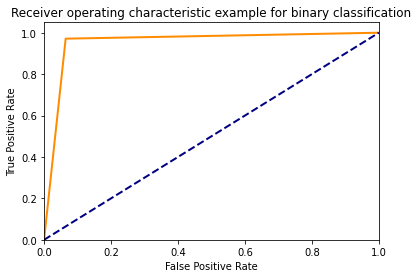

In [74]:
fpr, tpr, thresholds = roc_curve(np.array(test_y_new, dtype=int),
                                 [int(d) if d is not None else 1 for d in test_y_predicted_new],
                                 )

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example for binary classification')
plt.show()

In [75]:
thresholds

array([2, 1, 0])

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

def predict_embedded_with_model(test_x, train_x, train_y, model):
    model.fit(train_x, train_y)
    return model.predict(test_x)
params = {'n_estimators': 100,
          'max_depth': np.log10(train_x_embeded.__len__()) + 8,
          'min_samples_split': 2,
          'learning_rate': 0.1,
          'loss': 'ls'}
model_gradient_boost = GradientBoostingRegressor(**params)
test_y_int = [int(train_y[indx]) for indx in range(train_y.__len__())]
test_y_predicted_with_gradient_boosting = predict_embedded_with_model(l2_normalize(text_x_embeded), l2_normalize(train_x_embeded), train_y_new, model_gradient_boost)

np.mean([test_y_new[indx] == int(test_y_predicted_with_gradient_boosting[indx] > 0.5) for indx in range(test_y_predicted_with_gradient_boosting.__len__())])


0.7748344370860927

In [67]:
print('Accuracy: ', end=' ')
print(np.mean([test_y_new[indx] == int(test_y_predicted_with_gradient_boosting[indx] > 0.5) for indx in range(test_y_predicted_with_gradient_boosting.__len__())]))
print("True Positive:", end=' ')
print(np.mean([int(test_y_predicted_with_gradient_boosting[indx] > 0.5) == test_y_new[indx] for indx in range(med_val_test)]))
print("False Negative:", end=' ')
print(np.mean([int(test_y_predicted_with_gradient_boosting[indx] > 0.5) == test_y_new[indx] for indx in range(med_val_test, hight_board)]))
print("False Positive:", end=' ')
print(np.mean([int(test_y_predicted_with_gradient_boosting[indx] > 0.5) == 1 for indx in range(med_val_test)]))
print("True Negative:", end=' ')
print(np.mean([int(test_y_predicted_with_gradient_boosting[indx] > 0.5) == 0 for indx in range(med_val_test, hight_board)]))

Accuracy:  0.7774834437086092
True Positive: 0.7305785123966942
False Negative: 0.8088397790055248
False Positive: 0.2694214876033058
True Negative: 0.19116022099447513


In [55]:
l2_normalize(text_x_embeded)

array([[-0.05584079,  0.06928996,  0.00934372, ...,  0.04359949,
         0.03628165, -0.03382488],
       [-0.06560431,  0.08615842, -0.02441978, ...,  0.02027695,
         0.01909387, -0.02681961],
       [-0.05559166,  0.09168009,  0.01454109, ...,  0.02007023,
         0.03451925,  0.00537047],
       ...,
       [-0.03524285,  0.01511576, -0.03908692, ..., -0.04476959,
         0.02996436, -0.07710332],
       [-0.06462864,  0.03588438, -0.01792592, ..., -0.09329349,
         0.07809525,  0.02511544],
       [-0.007897  ,  0.01724644, -0.07008195, ..., -0.0460096 ,
        -0.00523441, -0.06152116]], dtype=float32)

In [10]:
!pip install catboost

You should consider upgrading via the 'c:\users\rost2\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11434 sha256=255461ebcafea5e82c064292a1b755da8c90f6d68f93bda0a9f0a1f19c32c58e
  Stored in directory: c:\users\rost2\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [23]:
from catboost import CatBoostClassifier, Pool

model_cat_boost = CatBoostClassifier(iterations=40,
                           depth=13,
                           learning_rate=.1,
                           loss_function='Logloss',
                           verbose=True)

test_y_predicted_with_gradient_boosting = predict_embedded_with_model(l2_normalize(text_x_embeded), l2_normalize(train_x_embeded), train_y_new, model_gradient_boost)

np.mean([test_y_new[indx] == int(test_y_predicted_with_gradient_boosting[indx] > 0.5) for indx in range(test_y_predicted_with_gradient_boosting.__len__())])

0.7675496688741722

In [24]:
!pip install pytorch-metric-learning

ERROR: Exception:
Traceback (most recent call last):
  File "c:\users\rost2\appdata\local\programs\python\python38\lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "c:\users\rost2\appdata\local\programs\python\python38\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "c:\users\rost2\appdata\local\programs\python\python38\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "c:\users\rost2\appdata\local\programs\python\python38\lib\http\client.py", line 458, in read
    n = self.readinto(b)
  File "c:\users\rost2\appdata\local\programs\python\python38\lib\http\client.py", line 502, in readinto
    n = self.fp.readinto(b)
  File "c:\users\rost2\appdata\local\programs\python\python38\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "c:\users\rost2\appdata\local\progra

In [ ]:
def predict_embedded(test_x, train_x, train_y):
    res = []
    for emb_test in test_x:
        min = 100
        res.append(None)
        for indx, emb_train in enumerate(train_x):
            min_new = distance.euclidean(emb_train, emb_test)
            if min_new < 1 and min > min_new:
                min = min_new
                res[-1] = train_y[indx]
    return res

test_y_predicted = predict_embedded(text_x_embeded, train_x_embeded, train_y)
test_y_predicted.__len__()